In [1]:
import scanpy as sc
from gtfparse import read_gtf
import pandas as pd
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=(5,5),dpi_save=600)
import scFates as scf
scf.set_figure_pubready()

In [2]:
df = read_gtf("Homo_sapiens.GRCh38.102.gtf",usecols=["gene_name","transcript_id"],
             column_converters={"gene_name": str, "transcript_id": str})
df=df.drop_duplicates(subset="transcript_id")
df.set_index("transcript_id",inplace=True)


tpm=pd.read_table("kallistoDerivedtpmRNASeq_values.tsv")
enst=list(map(lambda t: t.split(".")[1], tpm.index))
common=set.intersection(set(df.index.tolist()),set(enst))

enst=pd.DataFrame({"common":False,"gene":enst},index=enst)
enst.loc[common,"common"]=True
enst.loc[common,"gene"]=df.loc[common,"gene_name"].values
tpm.index=enst.gene.values

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
INFO:root:Extracted GTF attributes: ['gene_name', 'transcript_id']


In [3]:
tpm=tpm.sum(level=0)

<ipython-input-3-f70170c32bf1>:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  tpm=tpm.sum(level=0)


In [4]:
def cor_mat_gpu(A,B):
    import cupy as cp
    A1 = (A-cp.mean(A,axis=0))
    B1 = (B-cp.mean(B,axis=0))
    res = (B1.T.dot(A1)).T/cp.sqrt((A1**2).sum(axis=0).reshape(A1.shape[1],1) @ (B1**2).sum(axis=0).reshape(1,B1.shape[1]))
    return res.T

In [5]:
tpm

,syn5562035,syn5562037,syn5562015,syn5562019,syn5562021,syn5562023,syn5562025,syn5562029,syn5562031,syn10234227,syn10234233,syn10234229,syn10234228,syn10234230,syn10234234,syn10234231,syn10234236
TRDD1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
TRDD3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
TRDD2,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
IGHD3-16,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
IGHD4-23,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000631343,0.000000,0.000000,0.003208,0.0,0.0,0.000000,0.000000,0.0,0.0,0.071670,0.170551,0.036693,0.017898,0.0,0.000000,0.000000,0.0
ENST00000630654,0.026876,0.000000,0.023936,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.031118,0.000000,0.000000,0.0,0.000000,0.000000,0.0
ENST00000625398,0.022879,0.030605,0.005540,0.0,0.0,0.011139,0.000000,0.0,0.0,0.002674,0.006770,0.010675,0.000000,0.0,0.004856,0.000000,0.0
ENST00000630922,0.017745,0.057757,0.019057,0.0,0.0,0.036574,0.006187,0.0,0.0,0.000000,0.000000,0.010569,0.000000,0.0,0.000000,0.005995,0.0


In [6]:
from cupyx.scipy.sparse import csc_matrix as csc_matrix_gpu
import cupy as cp
def cor_sparse_pearson_gpu(X, Y=None, cov=False):

    nrows = X.shape[0]
    meanX = X.mean(axis=0)
    if Y is None:
        covmat = X.T * X - nrows * meanX.T * meanX
        covmat = covmat / (nrows - 1)
        var = cp.outer(cp.diag(covmat), cp.diag(covmat))
        cormat = cp.divide(covmat, cp.sqrt(var))
    else:
        meanY = Y.mean(axis=0)
        covmat = X.T * Y - nrows * meanX.T * meanY
        covmat = covmat / (nrows - 1)        
        meanX2 = cp.power(meanX, 2)
        meanY2 = cp.power(meanY, 2)
        sdX = cp.sqrt((X.power(2).sum(axis=0) - nrows * meanX2) / (nrows - 1))
        sdY = cp.sqrt((Y.power(2).sum(axis=0) - nrows * meanY2) / (nrows - 1))
        cormat = covmat / (sdX.T * sdY)
    if cov:
        return covmat
    return cormat

In [7]:
adata = sc.read('../../SS2/data/adata_assigned.h5ad')

In [8]:
import scipy.sparse as sp

In [9]:
import pandas as pd
ass_cols=pd.Series(adata.uns["assignments_colors"],index=adata.obs.assignments.cat.categories)

adata.obs.assignments=adata.obs.assignments.astype(str)
adata.obs.loc[adata.obs.Hub_leiden=="True","assignments"]="Hub"
adata.obs.assignments=adata.obs.assignments.astype("category")

ass_cols["Hub"]="lightgrey"

ass_cols["none"]="grey"

In [10]:
adata.var_names=adata.var_names.str.upper()
common=list(set.intersection(set(tpm.index),set(adata.var_names)))
adata=adata[:,common]

In [11]:
adata.X=sp.csc_matrix(adata.X.A)

In [12]:
import numpy as np
bulk=sp.csc_matrix(np.log10(tpm.loc[common,:]+1).values)
bulk=csc_matrix_gpu(bulk)
ss2=csc_matrix_gpu(adata.X)

In [13]:
import scvelo as scv
scv.tl.score_genes_cell_cycle(adata)

calculating cell cycle phase


Trying to set attribute `.obs` of view, copying.


-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


In [14]:
cc=cor_mat_gpu(cp.array(adata.obs.S_score.values.reshape(-1,1)),cp.array(adata.X.A))
cc=pd.Series(cc.get().ravel(),index=adata.var_names)
noncycling=cc[cc<0.1].index



In [15]:
ncc=adata.var_names.isin(noncycling)

In [16]:
cor=cor_sparse_pearson_gpu(ss2.T,bulk)

In [17]:
adata=sc.AnnData(cor.get(),obs=adata.obs,obsm=adata.obsm,uns=adata.uns)

In [18]:
adata

AnnData object with n_obs × n_vars = 8842 × 17
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'S_score', 'G2M_score', 'phase'
    uns: 'Hub_colors', 'devtime_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'paga', 'umap'
    obsm: 'X_diff', 'X_pca', 'X_umap'

In [19]:
adata.obs["correlation"]=0
for c in adata.obs.assignments.cat.categories:
    adata.obs.loc[adata.obs.assignments==c,"correlation"] = np.array(adata[adata.obs.assignments==c].X).mean()

<AxesSubplot:>

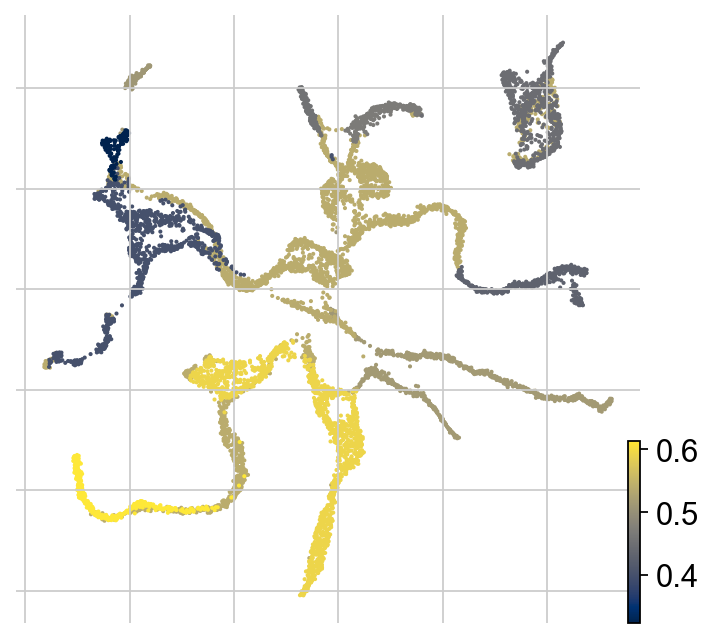

In [20]:
scv.pl.umap(adata[(adata.obs.correlation-adata.obs.correlation.mean()).abs().sort_values().index],
            title='',cmap='cividis',color="correlation",sort_order=False,show=False)

In [21]:
bulk.shape

(14999, 17)

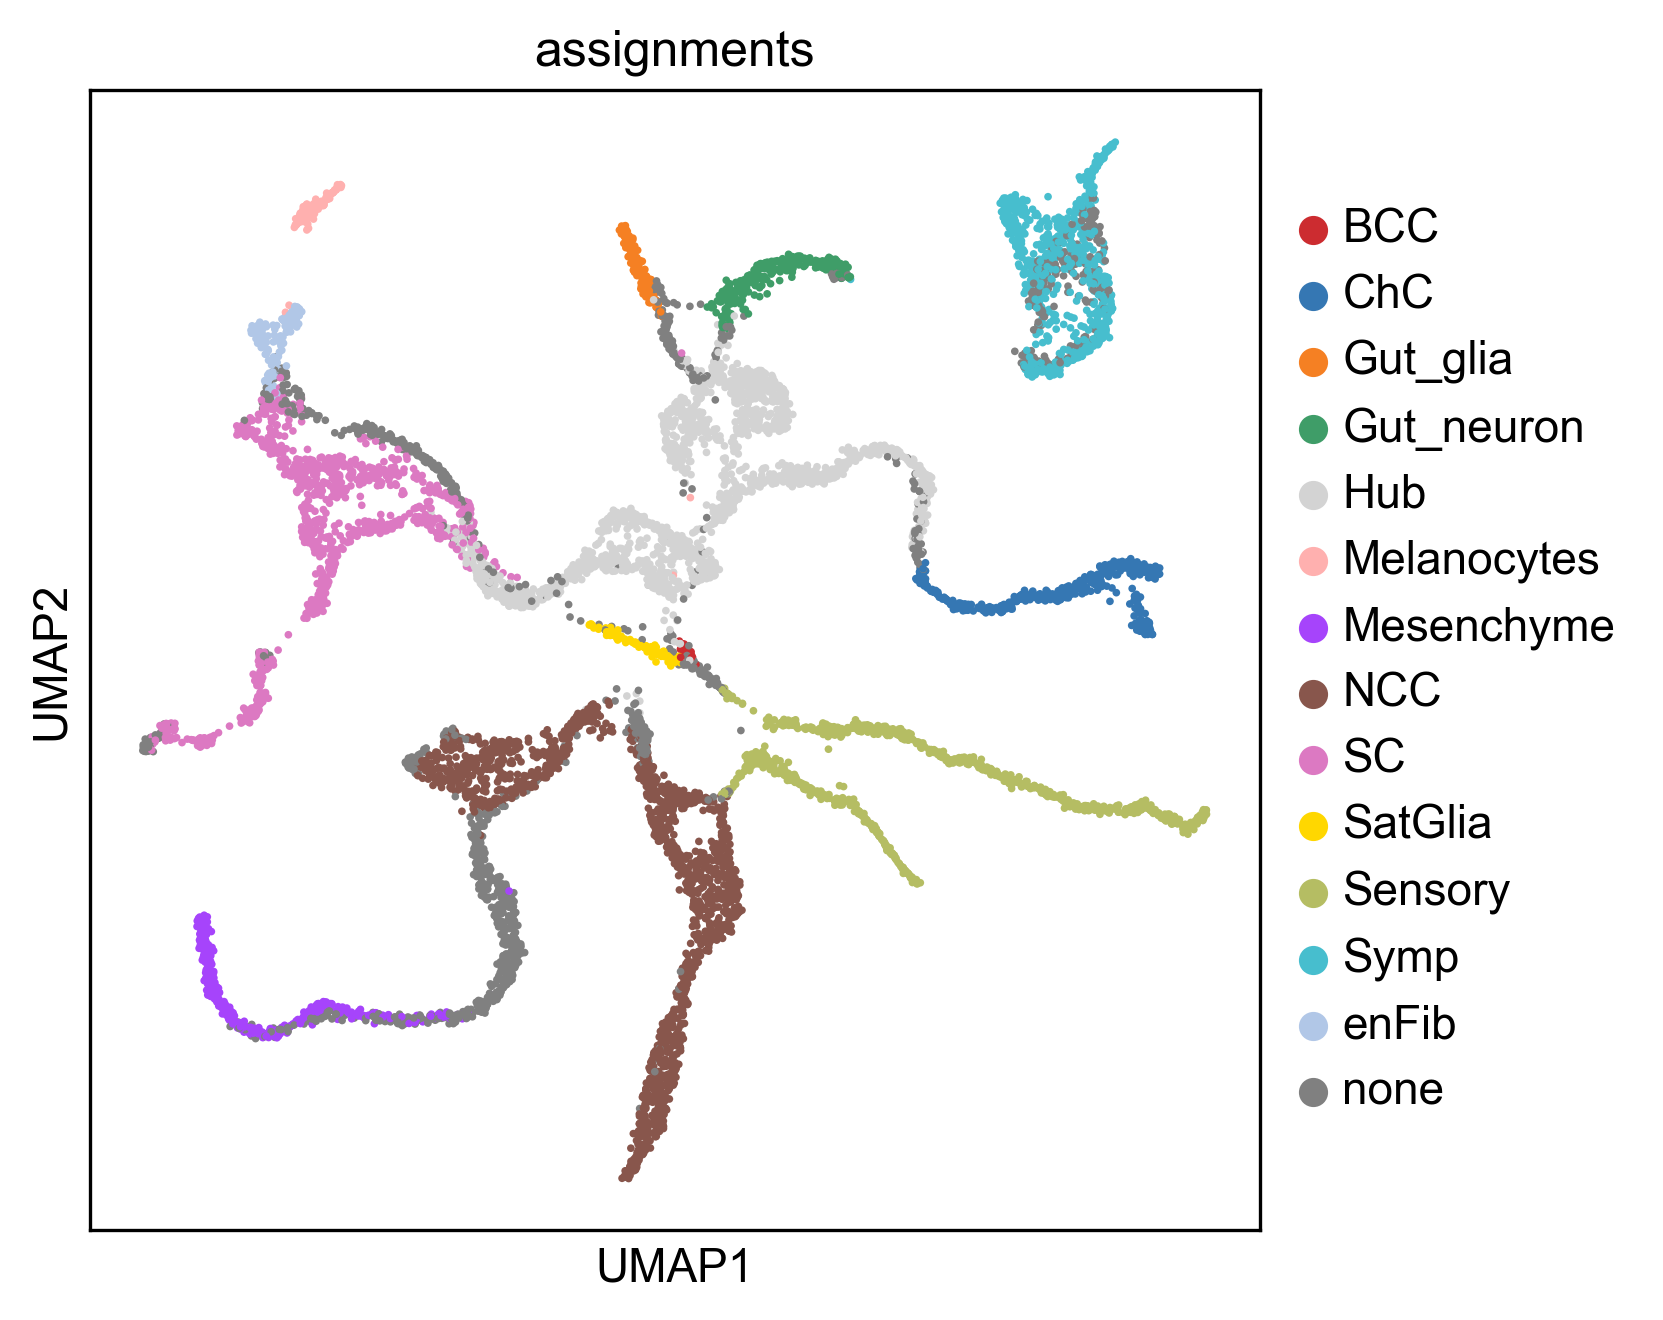

In [24]:
sc.pl.umap(adata_ncc,color="assignments",palette=[ass_cols[a] for a in adata_ncc.obs.assignments.cat.categories])


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'N', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 37, 38, 41, 49, 68, 69, 70, 7

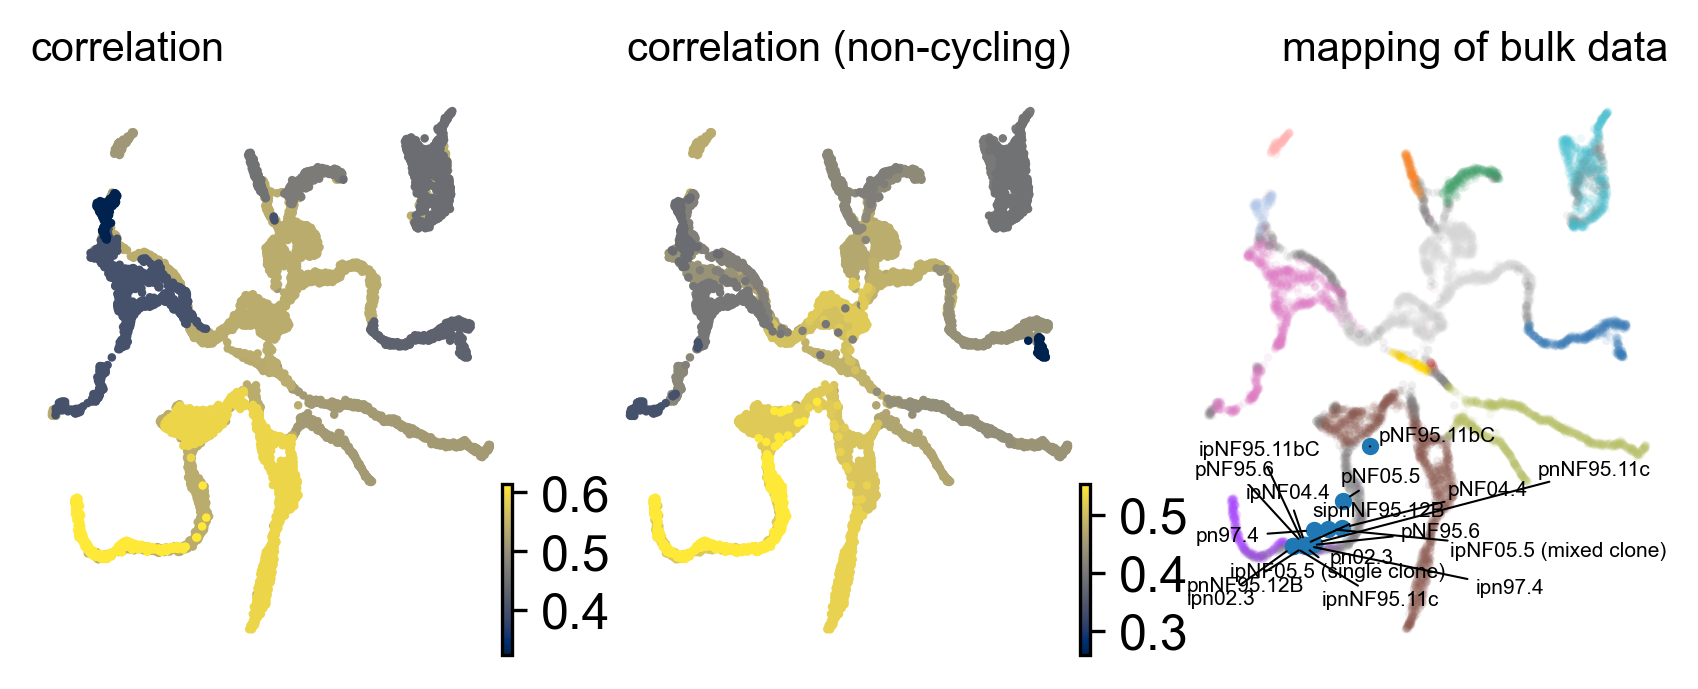

In [30]:
scv.set_figure_params(figsize=(5,5),dpi=150,frameon=False,fontsize=12,dpi_save=600)
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(7,2.5))


scv.pl.umap(adata[(adata.obs.correlation-adata.obs.correlation.mean()).abs().sort_values().index],
            title='',cmap='cividis',color="correlation",sort_order=False,ax=axs[0],show=False)

axs[0].set_title("correlation",loc='left',fontdict={'fontsize':10})




cor=cor_sparse_pearson_gpu(ss2[:,ncc].T,bulk[ncc,:])

adata_ncc=sc.AnnData(cor.get(),obs=adata.obs,obsm=adata.obsm,uns=adata.uns)

import numpy as np

adata_ncc.obs["correlation"]=0
for c in adata_ncc.obs.leiden.cat.categories:
    adata_ncc.obs.loc[adata_ncc.obs.leiden==c,"correlation"] = np.array(adata_ncc[adata_ncc.obs.leiden==c].X).mean()



scv.pl.umap(adata_ncc[(adata_ncc.obs.correlation-adata_ncc.obs.correlation.mean()).abs().sort_values().index],show=False,
           cmap='cividis',color="correlation",title="",sort_order=False,ax=axs[1])

axs[1].set_title("correlation (non-cycling)",loc='center',fontdict={'fontsize':10})

X=pd.DataFrame(adata_ncc.X.T,index=adata_ncc.T.obs_names,columns=adata_ncc.T.var_names)
umap_proj=X.apply(lambda b: pd.Series(adata_ncc[b.sort_values(ascending=False).index[:5]].obsm["X_umap"].mean(axis=0)),axis=1)
adata_ncc_bulk=adata_ncc.T
adata_ncc_bulk.obsm["X_umap"]=umap_proj.values

scv.pl.umap(adata_ncc,ax=axs[2],show=False,legend_loc=False,color="assignments",alpha=0.1,title='',
            palette=[ass_cols[a] for a in adata_ncc.obs.assignments.cat.categories])

axs[2].set_title("mapping of bulk data",loc='right',fontdict={'fontsize':10})


#sc.pl.umap(adata_ncc_bulk,ax=ax,add_outline=True,size=50)
celllines=["C8581ANXX_7","C8581ANXX_8","C856CANXX_1","C856CANXX_2","C856CANXX_3","C8581ANXX_1",
 "C8581ANXX_2","C8581ANXX_4","C8581ANXX_5","MR1_S1","MR5_S1","MR2_S2","MR19_S2",
 "MR3_S1","MR7_S2","MR4_S2","MR4_S2","MR8_S1"]
cellnames=pd.read_table("metadata.tsv",header=None,index_col=0).loc[celllines,1].values

axs[2].scatter(umap_proj.values[:,0],umap_proj.values[:,1],s=10)

from adjustText import adjust_text
texts = []
for x, y, l in zip(umap_proj.values[:,0].tolist(), 
                   umap_proj.values[:,1].tolist(),
                   cellnames.tolist()):
    texts.append(axs[2].text(x, y, l, fontsize=5))
    

adjust_text(texts,ax=axs[2],arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
        expand_text=(1.15, 1.15), expand_points=(1.15, 1.15),
        force_text=(0.25, 0.25), force_points=(0.25, 0.25))


plt.savefig('figures/overview.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'F', 'N', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 37, 38, 41, 49, 68, 69, 70, 7

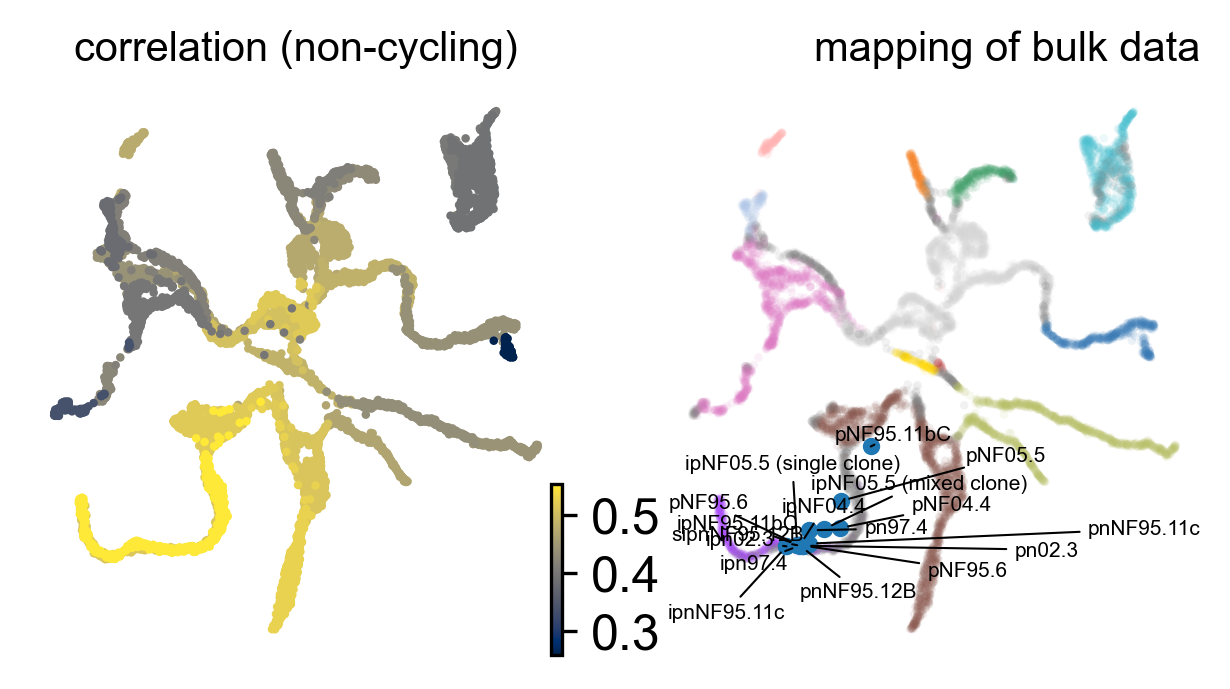

In [33]:
scv.set_figure_params(figsize=(5,5),dpi=150,frameon=False,fontsize=12,dpi_save=600)
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(5,2.5))



cor=cor_sparse_pearson_gpu(ss2[:,ncc].T,bulk[ncc,:])

adata_ncc=sc.AnnData(cor.get(),obs=adata.obs,obsm=adata.obsm,uns=adata.uns)

import numpy as np

adata_ncc.obs["correlation"]=0
for c in adata_ncc.obs.leiden.cat.categories:
    adata_ncc.obs.loc[adata_ncc.obs.leiden==c,"correlation"] = np.array(adata_ncc[adata_ncc.obs.leiden==c].X).mean()



scv.pl.umap(adata_ncc[(adata_ncc.obs.correlation-adata_ncc.obs.correlation.mean()).abs().sort_values().index],show=False,
           cmap='cividis',color="correlation",title="",sort_order=False,ax=axs[0])

axs[0].set_title("correlation (non-cycling)",loc='center',fontdict={'fontsize':10})

X=pd.DataFrame(adata_ncc.X.T,index=adata_ncc.T.obs_names,columns=adata_ncc.T.var_names)
umap_proj=X.apply(lambda b: pd.Series(adata_ncc[b.sort_values(ascending=False).index[:5]].obsm["X_umap"].mean(axis=0)),axis=1)
adata_ncc_bulk=adata_ncc.T
adata_ncc_bulk.obsm["X_umap"]=umap_proj.values

scv.pl.umap(adata_ncc,ax=axs[1],show=False,legend_loc=False,color="assignments",alpha=0.1,title='',
            palette=[ass_cols[a] for a in adata_ncc.obs.assignments.cat.categories])

axs[1].set_title("mapping of bulk data",loc='right',fontdict={'fontsize':10})


#sc.pl.umap(adata_ncc_bulk,ax=ax,add_outline=True,size=50)
celllines=["C8581ANXX_7","C8581ANXX_8","C856CANXX_1","C856CANXX_2","C856CANXX_3","C8581ANXX_1",
 "C8581ANXX_2","C8581ANXX_4","C8581ANXX_5","MR1_S1","MR5_S1","MR2_S2","MR19_S2",
 "MR3_S1","MR7_S2","MR4_S2","MR4_S2","MR8_S1"]
cellnames=pd.read_table("metadata.tsv",header=None,index_col=0).loc[celllines,1].values

axs[1].scatter(umap_proj.values[:,0],umap_proj.values[:,1],s=10)

from adjustText import adjust_text
texts = []
for x, y, l in zip(umap_proj.values[:,0].tolist(), 
                   umap_proj.values[:,1].tolist(),
                   cellnames.tolist()):
    texts.append(axs[1].text(x, y, l, fontsize=5))
    

adjust_text(texts,ax=axs[1],arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
        expand_text=(1.15, 1.15), expand_points=(1.15, 1.15),
        force_text=(0.25, 0.25), force_points=(0.25, 0.25))


plt.savefig('figures/overview.pdf')